# Task III - Estimating SLA Conformance and Violation from Device Statistics

  The objective for this task is to build a binary classifier function that estimates whether the VoD service conforms to the given SLA (18 frames/second) for specific device statistics X, or whether the service violates the SLA for a specific value of X.
  
  You apply logistic regression to build the classifier. As in the previous task, build a training set and a test set from the trace data, containing 70% of the observations and 30% of the observations, respectively.


## 1 Model Training
Model Training - use Logistic Regression to train a classifier C with the training set. Provide the coeffcients (⇥0,...,⇥10) of your model C. (⇥0 is the o↵set.) Give no more than three significant digits.


## 2
Accuracy of the Classifiers C - Compute the classification error (ERR) on the test set for C. For this, you first compute the confusion matrix, which includes the four numbers True Positives (TP), True Negatives (TN), False Positives (FN), and False Negatives (FN). We define the classification error as ERR = 1   T P +T N , whereby m is the number of observations in the test set. A true positive is an m observation that is correctly classified by the classifier as conforming to the SLA; a true negative is an observation that is correctly classified by the classifier as violating the SLA. Use confusion matrix plot to show TP,TN,FP, and FN.


### Solution:

Coefficients:  [[-9.38e-03  5.07e-03 -9.12e-03 -6.65e-06 -2.19e-03  9.94e-02  2.27e-03
  -7.43e-05  3.09e-02 -5.15e-02]]
ERR = 0.070
[[466  41]
 [ 35 538]]


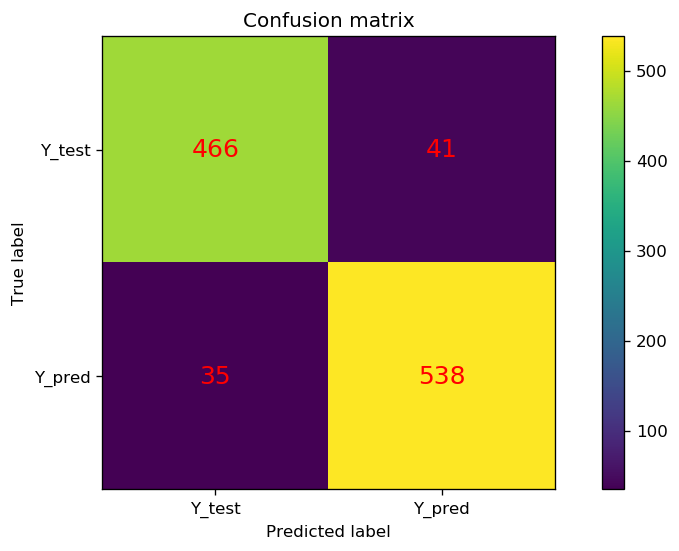

In [4]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics

# Read X,Y traces into pandas DataFrames named X,Y
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')

#create a single frame with selected columns
X_features = ['plist-sz', 'totsck','ldavg-1','pgfree/s','proc/s',
              'all_%%usr','file-nr','cswch/s','%%memused','runq-sz']
Y_features = ['DispFrames','low rate']

#create a new column of "low rate". if DisFrame >=18, it conforms to the SLA and will be set True. 
Y['low rate'] = Y['DispFrames']>= 18

# multiply it with 1 to change the set from True, False to 1, 0
Y['low rate'] = Y['low rate']*1 

#concatenate X[X_features], Y[Y_features] along a particular axis=1, a DataFrame is returned.
#Combine DataFrame objects horizontally along the x axis by passing in axis=1.
#(axis=0, a Series is returned)
XY = pd.concat([X[X_features], Y[Y_features]], axis=1)

# Producing training set and test set
train, test = train_test_split(XY, test_size = 0.3)

# Sort the train and test sets, sort_index defaults to column-wise(axis=0)
train = train.sort_index()
test = test.sort_index()

# Extract X,Y components from test and train sets
X_train = train[X_features]
X_test = test[X_features]
Y_train = train['low rate']
Y_test = test['low rate']

#Do logistic regression, C is the Inverse of regularization strength and default to be 1. 
#I set it as a big number of 1e5, which is 100000, to have the minimize regularization in order to avoid overfitting.
logreg = linear_model.LogisticRegression(C=1e5)

#Fit logistic model.
logreg.fit(X_train,Y_train)

#print coefficients
np.set_printoptions(precision=2)
print("Coefficients: ", logreg.coef_)

#predic
Y_pred = logreg.predict(X_test)


#==================================
#show TP,TN,FP,FN and ERR
#plot confusion matrix

#define the plotting function
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix'):    
    print(cm)
    #Display an image of cm data 
    plt.imshow(cm)
    plt.title(title)
    #Add a colorbar to a plot
    plt.colorbar()
    #get the range of X axis for X location
    xlocations = np.array(range(len(classes)))
    
    #set the current tick locations and labels of the x-axis.
    plt.xticks(xlocations, classes)
    plt.yticks(xlocations, classes)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
TP = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TN = cnf_matrix[1][1]
 
ERR = 1 - ((TP+TN)/1080)
print("ERR = %.3f" %ERR)

# Plot confusion matrix: design the size and resolution of the figure.
plt.figure(figsize=(10,5), dpi=120)

# return evenly spaced values within a given interval. Return [0,1]
ind_array = np.arange(2)

#Return coordinate matrices from coordinate vectors [0,1] [0,1].
x_mesh, y_mesh = np.meshgrid(ind_array, ind_array)

#Flatten() is to return a copy of the array collapsed into one dimension.
#zip() returns a object, which is an iterator of tuples where item in each iterator is paired together
for x_val, y_val in zip(x_mesh.flatten(), y_mesh.flatten()):
    #Get the value of TP, TN, FP, FN
    c = cnf_matrix[y_val][x_val]
    plt.text(x_val, y_val, c, color='red', fontsize=15, va='center', ha='center')

plot_confusion_matrix(cnf_matrix, classes=['Y_test','Y_pred'])
plt.show()




## 3
As a baseline for C, use a naive method which relies on Y values only, as follows. For each x belongs to X, the naive classifier predicts a value True with probability p and False with probability 1 - p. p is the fraction of Y values that conform with the SLA. Compute p on the training set and the classification error for the naive classifier on the test set.


In [2]:
#Naive method: predicts target variable in test set (Y_test) based on the knowledge of train set (train_Y) naively
#classifier is the mean of Y_train, the values are averagely around p
p = Y_train.mean()
print("naive classifier p = %.3f" %p)

#Correctly classified by the classifier as conforming to the SLA
TP_naive = Y_test & 1
#correctly classified by the classifier as violating the SLA
TN_naive = 1-(Y_test | 0)
ERR = 1 - ((sum(TP_naive)*p +sum(TN_naive)*(1-p))/1080)
print("ERR = %.3f" %ERR)




naive classifier p = 0.533
ERR = 0.498


## 4
Build a new classifier by extending extend the linear regression function developed in Task II with a check on the output, i.e., the Video Frame Rate. If the frame rate for a given X is above the SLA threshold, then the Y label of the classifier is set to conformance, otherwise to violation. Compute the new classifier on the training set and the classification error for this new classifier on the test set.


Coefficients: [-1.60e-02  1.82e-03 -7.85e-04 -6.15e-06 -1.01e-02  9.28e-02 -3.19e-03
 -8.22e-05  4.27e-01 -1.02e-02]
[[462  44]
 [ 31 543]]
ERR = 0.069


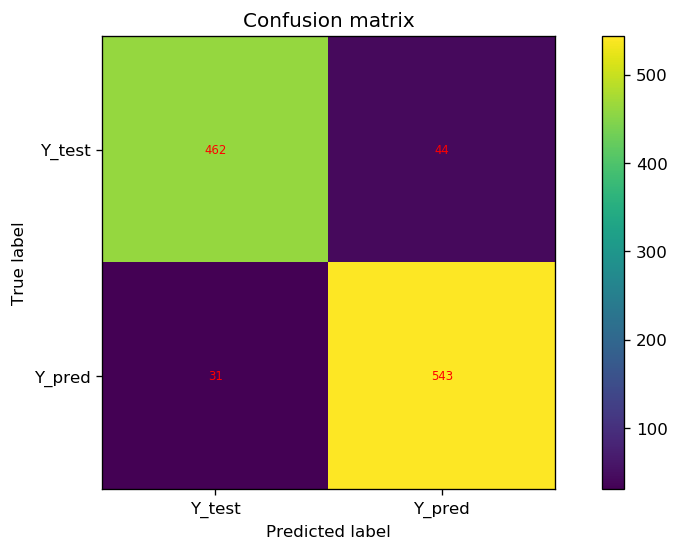

In [3]:
#get original Y_train of parameter "DispFrames"
Y_train_linear = train['DispFrames']
#Do linear regression
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train_linear)

#print coefficence, set precision to 2.
np.set_printoptions(precision=2)
print("Coefficients:", regr.coef_)

#predict from X_test, and transfer to DataFrame with title of DispFrames
Y_predict = regr.predict(X_test)
Y_predict =pd.DataFrame({'DispFrames': Y_predict})

#create a new column of "low rate". If DisFrame >=18, it conforms to the SLA and will be set True.
Y_predict['low rate'] = Y_predict['DispFrames']> 18

# multiply it with 1 to change the set from True, False to 1, 0
Y_predict['low rate'] = Y_predict['low rate']*1 

#convert from Series to DataFrame
Y_pre_linear = pd.DataFrame(Y_predict['low rate'])

#comput confusion matrix
cnf_matrix_naive = metrics.confusion_matrix(Y_test, Y_pre_linear)

#print TP, TN, FP, FN of confusion matrix
np.set_printoptions(precision=2) 
print(cnf_matrix_naive)

#calculate ERR
TP_naive = cnf_matrix_naive[0][0]
FP_naive = cnf_matrix_naive[0][1]
FN_naive = cnf_matrix_naive[1][0]
TN_naive = cnf_matrix_naive[1][1]
ERR_naive = 1 - ((TP_naive+TN_naive)/1080)
print("ERR = %.3f" %ERR_naive)

#define the plotting function
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix'):    
    #Display an image of cm data
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    
    #Get or set the current tick locations and labels of the x-axis.
    plt.xticks(xlocations, classes)
    plt.yticks(xlocations, classes)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix: design the size and resolution of the figure.
plt.figure(figsize=(10,5), dpi=120)

# return evenly spaced values within a given interval. Return [0,1]
ind_array = np.arange(2)

#Return coordinate matrices from coordinate vectors [0,1] [0,1].
x_mesh, y_mesh = np.meshgrid(ind_array, ind_array) 
for x_val, y_val in zip(x_mesh.flatten(), y_mesh.flatten()):
    c = cnf_matrix_naive[y_val][x_val]
    plt.text(x_val, y_val, c, color='red', fontsize=7, va='center', ha='center')

plot_confusion_matrix(cnf_matrix_naive, classes=['Y_test','Y_pred'])
plt.show()
